# 第6章补充：数据增强技术详解

> **学习目标：**
> - 理解数据增强的原理和重要性
> - 掌握常用的图像增强技术
> - 深入理解Mixup和CutMix的原理与实现
> - 了解自动数据增强（AutoAugment）的思想
> - 学会在实际项目中应用数据增强
>
> **前置知识：** 06_regularization.ipynb 的内容
>
> **学习时间：** 2-3小时

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# 尝试导入sklearn用于示例数据
from sklearn.datasets import load_digits

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',  # macOS通用
    'PingFang SC',       # macOS系统字体
    'STHeiti',           # 华文黑体
    'Heiti TC',          # 黑体-繁
    'SimHei',            # 黑体
]
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成！")

环境配置完成！


---

## 1. 数据增强概述

### 1.1 为什么需要数据增强？

数据增强（Data Augmentation）是一种**隐式的正则化技术**，通过人为扩充训练数据来：

1. **增加数据多样性**：让模型看到更多变化的样本
2. **减少过拟合**：相当于增加了训练集大小
3. **提高泛化能力**：让模型学会对变换不变的特征
4. **解决数据不足**：当标注数据有限时特别有用

### 1.2 数据增强的核心思想

**关键原则：增强后的数据应该保持标签不变**

例如，对于图像分类：
- 水平翻转一只猫 → 仍然是猫 ✓
- 旋转一个数字6变成9 → 标签改变了 ✗

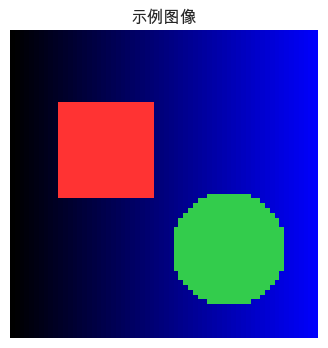

In [2]:
# 加载示例数据
def load_sample_images():
    """
    加载示例图像数据（使用sklearn的digits数据集）
    """
    digits = load_digits()
    # 取几个示例
    sample_indices = [0, 10, 20, 30, 40]
    images = digits.images[sample_indices]
    labels = digits.target[sample_indices]
    return images, labels

# 生成一个合成的彩色图像用于演示
def create_synthetic_image():
    """
    创建一个合成的彩色图像用于数据增强演示
    
    图像内容：一个简单的彩色方块和圆形
    """
    # 创建64x64的RGB图像
    img = np.zeros((64, 64, 3), dtype=np.float32)
    
    # 添加背景渐变
    for i in range(64):
        img[:, i, 2] = i / 64  # 蓝色渐变
    
    # 添加一个红色方块
    img[15:35, 10:30, 0] = 1.0
    img[15:35, 10:30, 1] = 0.2
    img[15:35, 10:30, 2] = 0.2
    
    # 添加一个绿色圆形
    center = (45, 45)
    radius = 12
    for i in range(64):
        for j in range(64):
            if (i - center[0])**2 + (j - center[1])**2 < radius**2:
                img[i, j, 0] = 0.2
                img[i, j, 1] = 0.8
                img[i, j, 2] = 0.3
    
    return img

# 创建示例图像
sample_image = create_synthetic_image()

plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title('示例图像')
plt.axis('off')
plt.show()

---

## 2. 基础图像增强技术

### 2.1 几何变换

几何变换改变图像的空间结构，包括：
- 翻转（Flip）
- 旋转（Rotation）
- 缩放（Scale）
- 平移（Translation）
- 剪切（Shear）

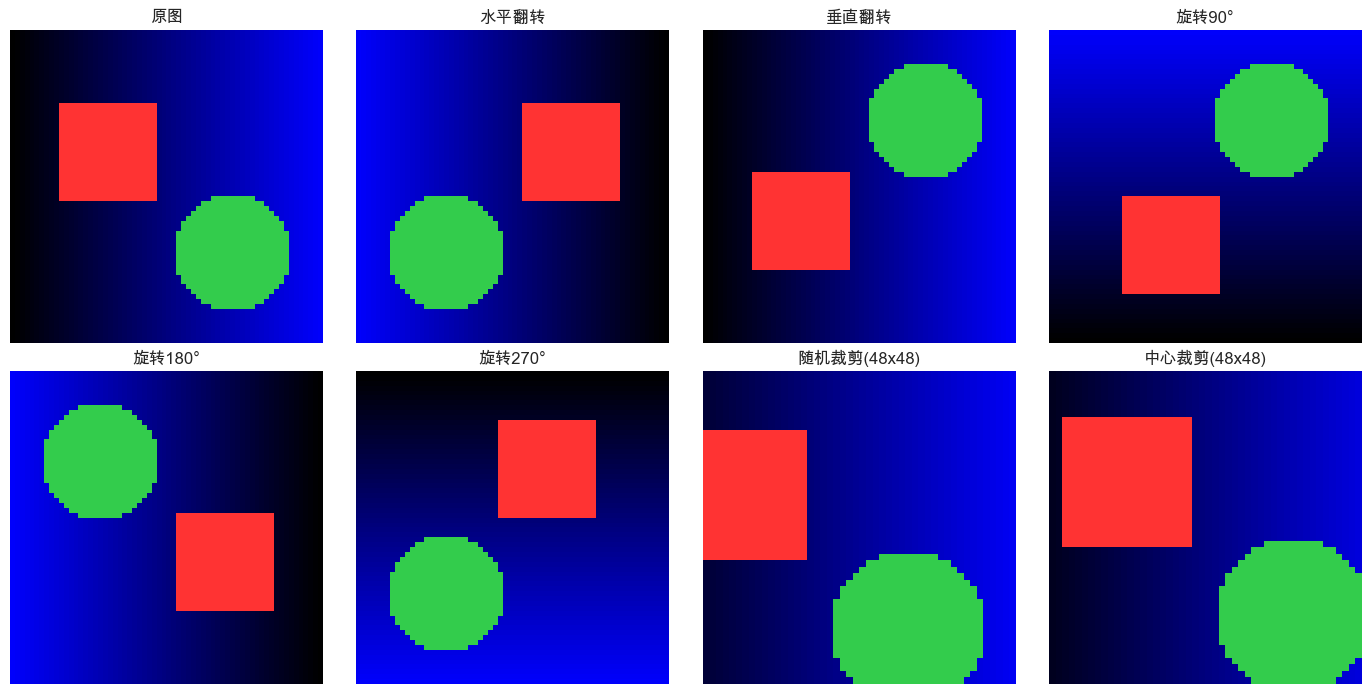

In [3]:
class GeometricTransforms:
    """
    几何变换类 - 从零实现常用的几何图像增强
    
    包含:
        - 水平翻转
        - 垂直翻转
        - 旋转90度
        - 随机裁剪
    """
    
    @staticmethod
    def horizontal_flip(image):
        """
        水平翻转图像（左右镜像）
        
        参数:
            image: numpy数组, shape: (H, W) 或 (H, W, C)
        
        返回:
            翻转后的图像
        
        实现原理:
            将每一行的像素顺序反转
            等价于 image[:, ::-1] 或 image[:, ::-1, :]
        """
        # np.fliplr: 沿水平轴翻转（left-right）
        return np.fliplr(image)
    
    @staticmethod
    def vertical_flip(image):
        """
        垂直翻转图像（上下镜像）
        
        参数:
            image: numpy数组, shape: (H, W) 或 (H, W, C)
        
        返回:
            翻转后的图像
        
        实现原理:
            将每一列的像素顺序反转
            等价于 image[::-1, :] 或 image[::-1, :, :]
        """
        # np.flipud: 沿垂直轴翻转（up-down）
        return np.flipud(image)
    
    @staticmethod
    def rotate_90(image, k=1):
        """
        将图像旋转90度的倍数
        
        参数:
            image: numpy数组, shape: (H, W) 或 (H, W, C)
            k: int, 旋转次数（每次90度，逆时针）
               k=1: 90度, k=2: 180度, k=3: 270度
        
        返回:
            旋转后的图像
        """
        # np.rot90: 逆时针旋转90度，k次
        return np.rot90(image, k=k)
    
    @staticmethod
    def random_crop(image, crop_size):
        """
        随机裁剪图像
        
        参数:
            image: numpy数组, shape: (H, W) 或 (H, W, C)
            crop_size: tuple, (crop_h, crop_w) 裁剪后的尺寸
        
        返回:
            裁剪后的图像
        
        实现原理:
            1. 计算可行的裁剪起始位置范围
            2. 随机选择起始位置
            3. 从起始位置裁剪指定大小的区域
        """
        h, w = image.shape[:2]
        crop_h, crop_w = crop_size
        
        # 检查裁剪尺寸是否合法
        if crop_h > h or crop_w > w:
            raise ValueError(f"裁剪尺寸{crop_size}大于图像尺寸{(h, w)}")
        
        # 随机选择裁剪起始位置
        # top: 上边界位置，范围[0, h - crop_h]
        # left: 左边界位置，范围[0, w - crop_w]
        top = np.random.randint(0, h - crop_h + 1)
        left = np.random.randint(0, w - crop_w + 1)
        
        # 执行裁剪
        if len(image.shape) == 3:
            return image[top:top+crop_h, left:left+crop_w, :]
        else:
            return image[top:top+crop_h, left:left+crop_w]
    
    @staticmethod
    def center_crop(image, crop_size):
        """
        中心裁剪图像
        
        参数:
            image: numpy数组
            crop_size: tuple, (crop_h, crop_w)
        
        返回:
            从中心裁剪的图像
        """
        h, w = image.shape[:2]
        crop_h, crop_w = crop_size
        
        # 计算中心裁剪的起始位置
        top = (h - crop_h) // 2
        left = (w - crop_w) // 2
        
        if len(image.shape) == 3:
            return image[top:top+crop_h, left:left+crop_w, :]
        else:
            return image[top:top+crop_h, left:left+crop_w]


# 演示几何变换
def demo_geometric_transforms():
    """
    演示各种几何变换的效果
    """
    transforms = GeometricTransforms()
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    
    # 原图
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('原图')
    axes[0, 0].axis('off')
    
    # 水平翻转
    h_flip = transforms.horizontal_flip(sample_image)
    axes[0, 1].imshow(h_flip)
    axes[0, 1].set_title('水平翻转')
    axes[0, 1].axis('off')
    
    # 垂直翻转
    v_flip = transforms.vertical_flip(sample_image)
    axes[0, 2].imshow(v_flip)
    axes[0, 2].set_title('垂直翻转')
    axes[0, 2].axis('off')
    
    # 旋转90度
    rot90 = transforms.rotate_90(sample_image, k=1)
    axes[0, 3].imshow(rot90)
    axes[0, 3].set_title('旋转90°')
    axes[0, 3].axis('off')
    
    # 旋转180度
    rot180 = transforms.rotate_90(sample_image, k=2)
    axes[1, 0].imshow(rot180)
    axes[1, 0].set_title('旋转180°')
    axes[1, 0].axis('off')
    
    # 旋转270度
    rot270 = transforms.rotate_90(sample_image, k=3)
    axes[1, 1].imshow(rot270)
    axes[1, 1].set_title('旋转270°')
    axes[1, 1].axis('off')
    
    # 随机裁剪
    crop = transforms.random_crop(sample_image, (48, 48))
    axes[1, 2].imshow(crop)
    axes[1, 2].set_title('随机裁剪(48x48)')
    axes[1, 2].axis('off')
    
    # 中心裁剪
    center = transforms.center_crop(sample_image, (48, 48))
    axes[1, 3].imshow(center)
    axes[1, 3].set_title('中心裁剪(48x48)')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

demo_geometric_transforms()

### 2.2 颜色变换

颜色变换改变图像的像素值，包括：
- 亮度调整（Brightness）
- 对比度调整（Contrast）
- 饱和度调整（Saturation）
- 色调调整（Hue）
- 颜色抖动（Color Jitter）

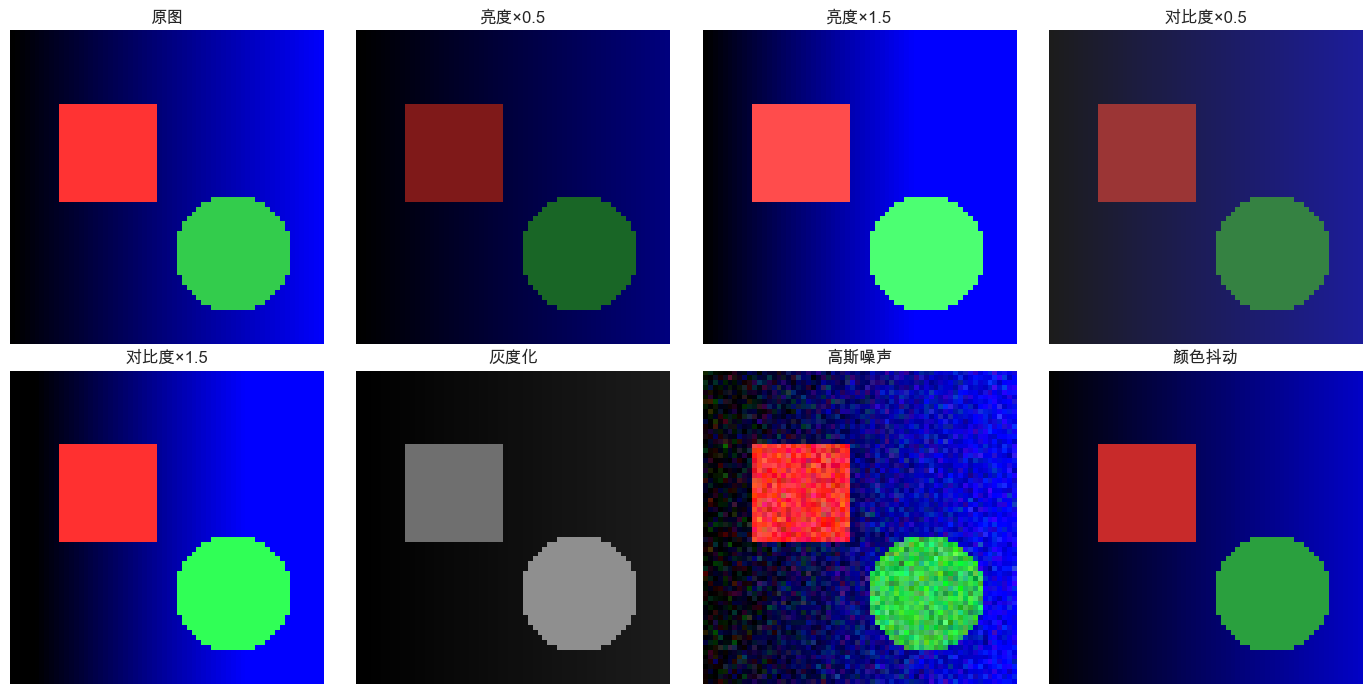

In [4]:
class ColorTransforms:
    """
    颜色变换类 - 从零实现常用的颜色图像增强
    
    包含:
        - 亮度调整
        - 对比度调整
        - 灰度化
        - 颜色抖动
    """
    
    @staticmethod
    def adjust_brightness(image, factor):
        """
        调整图像亮度
        
        参数:
            image: numpy数组, shape: (H, W, C), 值范围[0, 1]
            factor: float, 亮度因子
                    factor=1.0 不变
                    factor<1.0 变暗
                    factor>1.0 变亮
        
        返回:
            调整亮度后的图像
        
        实现原理:
            简单地将所有像素值乘以factor
            然后裁剪到[0, 1]范围内
        """
        # 乘以亮度因子
        result = image * factor
        # 裁剪到合法范围
        return np.clip(result, 0, 1)
    
    @staticmethod
    def adjust_contrast(image, factor):
        """
        调整图像对比度
        
        参数:
            image: numpy数组, shape: (H, W, C), 值范围[0, 1]
            factor: float, 对比度因子
                    factor=1.0 不变
                    factor<1.0 降低对比度（向灰色靠拢）
                    factor>1.0 增加对比度（远离灰色）
        
        返回:
            调整对比度后的图像
        
        实现原理:
            1. 计算图像的平均值（灰度中心）
            2. 将像素值向中心移动或远离中心
            公式: new_pixel = mean + factor * (old_pixel - mean)
        """
        # 计算图像平均值
        mean = np.mean(image)
        # 调整对比度：以mean为中心缩放
        result = mean + factor * (image - mean)
        return np.clip(result, 0, 1)
    
    @staticmethod
    def to_grayscale(image):
        """
        将彩色图像转换为灰度图像
        
        参数:
            image: numpy数组, shape: (H, W, C)
        
        返回:
            灰度图像, shape: (H, W, C)，三个通道值相同
        
        实现原理:
            使用标准的RGB到灰度转换公式
            Gray = 0.299*R + 0.587*G + 0.114*B
            这个权重考虑了人眼对不同颜色的敏感度
        """
        # RGB到灰度的标准权重
        weights = np.array([0.299, 0.587, 0.114])
        # 计算加权和
        gray = np.sum(image * weights, axis=2, keepdims=True)
        # 复制到三个通道
        return np.repeat(gray, 3, axis=2)
    
    @staticmethod
    def add_noise(image, noise_type='gaussian', amount=0.05):
        """
        向图像添加噪声
        
        参数:
            image: numpy数组
            noise_type: str, 'gaussian' 或 'salt_pepper'
            amount: float, 噪声强度
        
        返回:
            添加噪声后的图像
        """
        if noise_type == 'gaussian':
            # 高斯噪声：添加正态分布的随机值
            noise = np.random.normal(0, amount, image.shape)
            result = image + noise
        elif noise_type == 'salt_pepper':
            # 椒盐噪声：随机将像素设为0或1
            result = image.copy()
            # 盐噪声（白点）
            salt_mask = np.random.random(image.shape[:2]) < amount / 2
            result[salt_mask] = 1
            # 椒噪声（黑点）
            pepper_mask = np.random.random(image.shape[:2]) < amount / 2
            result[pepper_mask] = 0
        else:
            raise ValueError(f"未知的噪声类型: {noise_type}")
        
        return np.clip(result, 0, 1)
    
    @staticmethod
    def color_jitter(image, brightness=0.2, contrast=0.2):
        """
        随机颜色抖动
        
        参数:
            image: numpy数组
            brightness: float, 亮度抖动范围
            contrast: float, 对比度抖动范围
        
        返回:
            颜色抖动后的图像
        """
        result = image.copy()
        
        # 随机亮度调整
        b_factor = 1 + np.random.uniform(-brightness, brightness)
        result = ColorTransforms.adjust_brightness(result, b_factor)
        
        # 随机对比度调整
        c_factor = 1 + np.random.uniform(-contrast, contrast)
        result = ColorTransforms.adjust_contrast(result, c_factor)
        
        return result


# 演示颜色变换
def demo_color_transforms():
    """
    演示各种颜色变换的效果
    """
    transforms = ColorTransforms()
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    
    # 原图
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('原图')
    axes[0, 0].axis('off')
    
    # 变暗
    dark = transforms.adjust_brightness(sample_image, 0.5)
    axes[0, 1].imshow(dark)
    axes[0, 1].set_title('亮度×0.5')
    axes[0, 1].axis('off')
    
    # 变亮
    bright = transforms.adjust_brightness(sample_image, 1.5)
    axes[0, 2].imshow(bright)
    axes[0, 2].set_title('亮度×1.5')
    axes[0, 2].axis('off')
    
    # 低对比度
    low_contrast = transforms.adjust_contrast(sample_image, 0.5)
    axes[0, 3].imshow(low_contrast)
    axes[0, 3].set_title('对比度×0.5')
    axes[0, 3].axis('off')
    
    # 高对比度
    high_contrast = transforms.adjust_contrast(sample_image, 1.5)
    axes[1, 0].imshow(high_contrast)
    axes[1, 0].set_title('对比度×1.5')
    axes[1, 0].axis('off')
    
    # 灰度
    gray = transforms.to_grayscale(sample_image)
    axes[1, 1].imshow(gray)
    axes[1, 1].set_title('灰度化')
    axes[1, 1].axis('off')
    
    # 高斯噪声
    noisy = transforms.add_noise(sample_image, 'gaussian', 0.1)
    axes[1, 2].imshow(noisy)
    axes[1, 2].set_title('高斯噪声')
    axes[1, 2].axis('off')
    
    # 颜色抖动
    jittered = transforms.color_jitter(sample_image, 0.3, 0.3)
    axes[1, 3].imshow(jittered)
    axes[1, 3].set_title('颜色抖动')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

demo_color_transforms()

### 2.3 擦除增强

擦除类增强通过遮挡图像的一部分来提高模型的鲁棒性：
- Cutout: 随机擦除矩形区域
- Random Erasing: 随机擦除并填充随机值

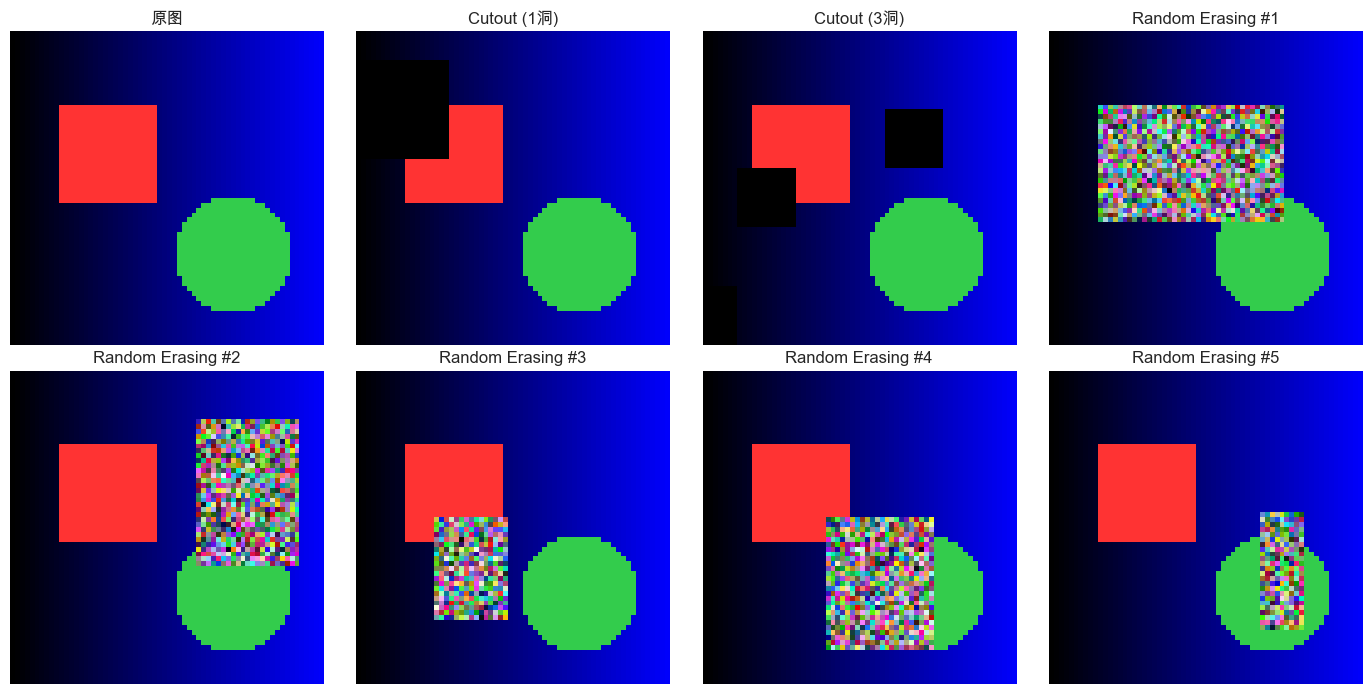

In [5]:
class ErasingTransforms:
    """
    擦除类增强 - 从零实现
    
    核心思想：
        通过遮挡图像的部分区域，强迫模型学习更鲁棒的特征
        模型不能依赖单一区域，必须学会从多个区域综合判断
    """
    
    @staticmethod
    def cutout(image, n_holes=1, hole_size=16):
        """
        Cutout增强 - 随机擦除正方形区域
        
        参数:
            image: numpy数组, shape: (H, W, C)
            n_holes: int, 擦除区域的数量
            hole_size: int, 每个擦除区域的边长
        
        返回:
            擦除后的图像
        
        论文: "Improved Regularization of Convolutional Neural Networks 
               with Cutout" (2017)
        """
        h, w = image.shape[:2]
        result = image.copy()
        
        for _ in range(n_holes):
            # 随机选择擦除区域的中心点
            center_y = np.random.randint(0, h)
            center_x = np.random.randint(0, w)
            
            # 计算擦除区域的边界（考虑图像边界）
            # 使用 // 确保整数除法
            y1 = max(0, center_y - hole_size // 2)
            y2 = min(h, center_y + hole_size // 2)
            x1 = max(0, center_x - hole_size // 2)
            x2 = min(w, center_x + hole_size // 2)
            
            # 将区域设为0（黑色）
            result[y1:y2, x1:x2] = 0
        
        return result
    
    @staticmethod
    def random_erasing(image, p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)):
        """
        Random Erasing增强 - 随机擦除并填充随机值
        
        参数:
            image: numpy数组, shape: (H, W, C)
            p: float, 执行擦除的概率
            scale: tuple, 擦除区域占图像面积的比例范围
            ratio: tuple, 擦除区域的宽高比范围
        
        返回:
            擦除后的图像
        
        论文: "Random Erasing Data Augmentation" (2020)
        """
        # 以概率p执行擦除
        if np.random.random() > p:
            return image
        
        h, w = image.shape[:2]
        area = h * w
        result = image.copy()
        
        # 尝试多次找到合适的擦除区域
        for _ in range(100):
            # 随机选择擦除区域的面积
            target_area = np.random.uniform(scale[0], scale[1]) * area
            
            # 随机选择宽高比
            aspect_ratio = np.random.uniform(ratio[0], ratio[1])
            
            # 根据面积和宽高比计算擦除区域的宽和高
            erase_h = int(round(np.sqrt(target_area * aspect_ratio)))
            erase_w = int(round(np.sqrt(target_area / aspect_ratio)))
            
            # 检查尺寸是否合法
            if erase_h < h and erase_w < w:
                # 随机选择擦除位置
                top = np.random.randint(0, h - erase_h)
                left = np.random.randint(0, w - erase_w)
                
                # 填充随机值（与原论文一致）
                random_fill = np.random.random((erase_h, erase_w, image.shape[2]))
                result[top:top+erase_h, left:left+erase_w] = random_fill
                
                return result
        
        # 如果100次都没找到合适的区域，返回原图
        return image


# 演示擦除增强
def demo_erasing_transforms():
    """
    演示擦除类增强的效果
    """
    transforms = ErasingTransforms()
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    
    # 原图
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('原图')
    axes[0, 0].axis('off')
    
    # Cutout - 1个洞
    cutout1 = transforms.cutout(sample_image, n_holes=1, hole_size=20)
    axes[0, 1].imshow(cutout1)
    axes[0, 1].set_title('Cutout (1洞)')
    axes[0, 1].axis('off')
    
    # Cutout - 多个洞
    cutout3 = transforms.cutout(sample_image, n_holes=3, hole_size=12)
    axes[0, 2].imshow(cutout3)
    axes[0, 2].set_title('Cutout (3洞)')
    axes[0, 2].axis('off')
    
    # Random Erasing
    for i in range(5):
        if i < 4:
            ax = axes.flat[3 + i]
        else:
            ax = axes[1, 3]
        re = transforms.random_erasing(sample_image, p=1.0)
        ax.imshow(re)
        ax.set_title(f'Random Erasing #{i+1}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

demo_erasing_transforms()

---

## 3. Mixup数据增强

### 3.1 Mixup原理

Mixup是一种**混合样本**的数据增强方法，通过线性插值创建虚拟训练样本。

**核心公式：**

$$\tilde{x} = \lambda x_i + (1 - \lambda) x_j$$
$$\tilde{y} = \lambda y_i + (1 - \lambda) y_j$$

其中：
- $(x_i, y_i)$ 和 $(x_j, y_j)$ 是两个随机采样的训练样本
- $\lambda \sim \text{Beta}(\alpha, \alpha)$，通常 $\alpha = 0.2$
- $(\tilde{x}, \tilde{y})$ 是混合后的新样本

**关键洞察：**
- 标签也被混合！这是Mixup与传统增强的关键区别
- 模型被训练来预测"软标签"，而不是硬标签
- 这鼓励模型产生更平滑的决策边界

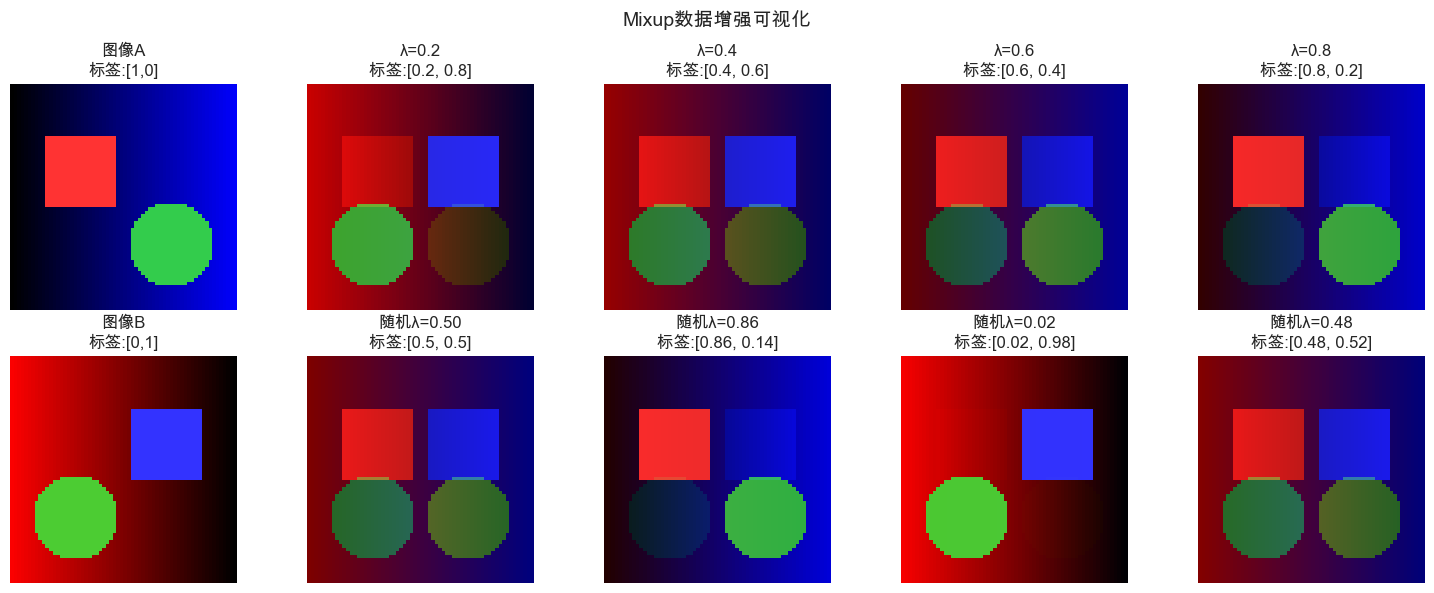

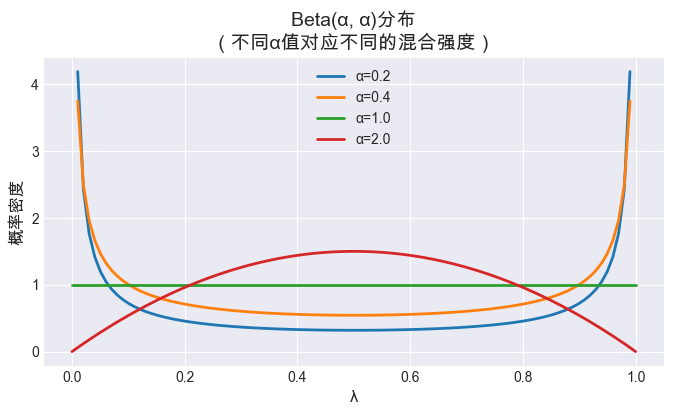

In [6]:
class Mixup:
    """
    Mixup数据增强 - 从零实现
    
    论文: "mixup: Beyond Empirical Risk Minimization" (ICLR 2018)
    
    核心思想:
        - 通过线性插值混合两个样本及其标签
        - 创建虚拟的训练样本，扩展训练分布
        - 产生更平滑的决策边界，提高泛化能力
    
    优点:
        - 实现简单
        - 无额外计算开销（训练时混合）
        - 对各种模型和任务都有效
    """
    
    def __init__(self, alpha=0.2):
        """
        初始化Mixup
        
        参数:
            alpha: float, Beta分布的参数
                   alpha=0: 不混合（退化为标准训练）
                   alpha=1: 均匀分布，强混合
                   推荐值: 0.2 - 0.4
        """
        self.alpha = alpha
    
    def sample_lambda(self):
        """
        从Beta分布采样混合系数λ
        
        返回:
            float: λ ∈ [0, 1]
        
        Beta分布的性质:
            - α = β 时分布对称
            - α < 1 时分布呈U形，倾向于取接近0或1的值
            - α > 1 时分布呈倒U形，倾向于取接近0.5的值
        """
        if self.alpha > 0:
            # 从Beta(α, α)采样
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            # alpha=0时不混合
            lam = 1.0
        return lam
    
    def mix_samples(self, x1, y1, x2, y2):
        """
        混合两个样本
        
        参数:
            x1, x2: numpy数组, 输入图像
            y1, y2: numpy数组, one-hot编码的标签
        
        返回:
            mixed_x: 混合后的图像
            mixed_y: 混合后的标签（软标签）
            lam: 使用的混合系数
        
        公式:
            x̃ = λ * x1 + (1-λ) * x2
            ỹ = λ * y1 + (1-λ) * y2
        """
        lam = self.sample_lambda()
        
        # 混合图像
        mixed_x = lam * x1 + (1 - lam) * x2
        
        # 混合标签（软标签）
        mixed_y = lam * y1 + (1 - lam) * y2
        
        return mixed_x, mixed_y, lam
    
    def mix_batch(self, batch_x, batch_y):
        """
        对一个batch进行Mixup
        
        参数:
            batch_x: numpy数组, shape: (batch_size, H, W, C)
            batch_y: numpy数组, shape: (batch_size, n_classes), one-hot编码
        
        返回:
            mixed_x: 混合后的batch
            mixed_y: 混合后的标签
            lam: 使用的混合系数
        
        策略:
            将batch打乱，然后与原batch混合
            这样每个样本都与另一个随机样本混合
        """
        batch_size = len(batch_x)
        lam = self.sample_lambda()
        
        # 随机打乱索引
        shuffle_indices = np.random.permutation(batch_size)
        
        # 混合
        mixed_x = lam * batch_x + (1 - lam) * batch_x[shuffle_indices]
        mixed_y = lam * batch_y + (1 - lam) * batch_y[shuffle_indices]
        
        return mixed_x, mixed_y, lam


# 可视化Mixup效果
def visualize_mixup():
    """
    可视化Mixup的混合效果
    """
    # 创建第二个示例图像
    sample_image2 = create_synthetic_image()
    # 翻转并调整颜色使其与第一个图像不同
    sample_image2 = np.fliplr(sample_image2)
    sample_image2[:, :, 0], sample_image2[:, :, 2] = \
        sample_image2[:, :, 2].copy(), sample_image2[:, :, 0].copy()
    
    mixup = Mixup(alpha=0.4)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    # 第一行：原始图像和不同λ值的混合结果
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('图像A\n标签:[1,0]')
    axes[0, 0].axis('off')
    
    lambda_values = [0.2, 0.4, 0.6, 0.8]
    for i, lam in enumerate(lambda_values):
        mixed = lam * sample_image + (1 - lam) * sample_image2
        axes[0, i+1].imshow(mixed)
        mixed_label = [lam, 1-lam]
        axes[0, i+1].set_title(f'λ={lam}\n标签:{[round(l,1) for l in mixed_label]}')
        axes[0, i+1].axis('off')
    
    # 第二行
    axes[1, 0].imshow(sample_image2)
    axes[1, 0].set_title('图像B\n标签:[0,1]')
    axes[1, 0].axis('off')
    
    # 随机采样几个λ值
    for i in range(4):
        mixed_x, mixed_y, lam = mixup.mix_samples(
            sample_image, np.array([1, 0]),
            sample_image2, np.array([0, 1])
        )
        axes[1, i+1].imshow(np.clip(mixed_x, 0, 1))
        axes[1, i+1].set_title(f'随机λ={lam:.2f}\n标签:{[round(l,2) for l in mixed_y]}')
        axes[1, i+1].axis('off')
    
    plt.suptitle('Mixup数据增强可视化', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 可视化Beta分布
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.linspace(0, 1, 100)
    
    for alpha in [0.2, 0.4, 1.0, 2.0]:
        from scipy.stats import beta
        y = beta.pdf(x, alpha, alpha)
        ax.plot(x, y, label=f'α={alpha}', linewidth=2)
    
    ax.set_xlabel('λ', fontsize=12)
    ax.set_ylabel('概率密度', fontsize=12)
    ax.set_title('Beta(α, α)分布\n（不同α值对应不同的混合强度）', fontsize=14)
    ax.legend()
    plt.show()

visualize_mixup()

---

## 4. CutMix数据增强

### 4.1 CutMix原理

CutMix结合了Cutout和Mixup的思想：
- 从一个图像中**剪切**一个区域
- 用另一个图像的对应区域**填充**
- 标签按照面积比例**混合**

**公式：**

$$\tilde{x} = M \odot x_i + (1 - M) \odot x_j$$
$$\tilde{y} = \lambda y_i + (1 - \lambda) y_j$$

其中：
- $M$ 是一个二值掩码（1表示保留$x_i$，0表示使用$x_j$）
- $\lambda = 1 - \frac{r_w \times r_h}{W \times H}$ 是保留区域的面积比例
- $\odot$ 表示逐元素乘法

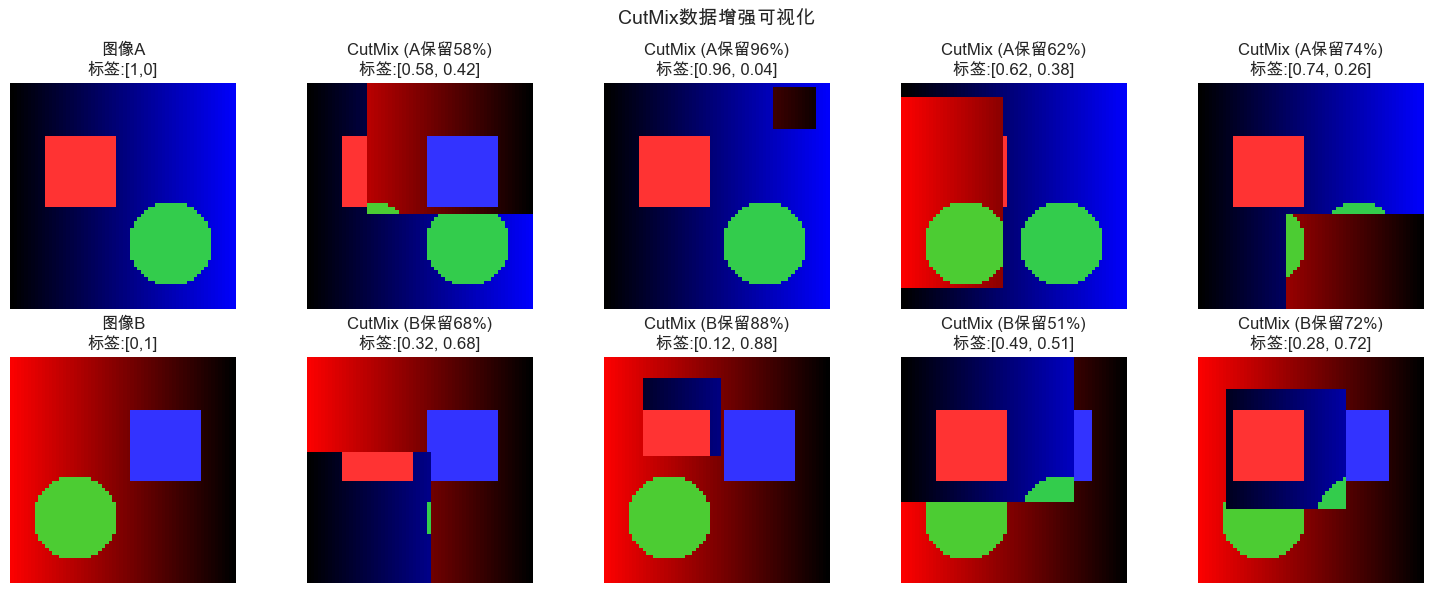

In [7]:
class CutMix:
    """
    CutMix数据增强 - 从零实现
    
    论文: "CutMix: Regularization Strategy to Train Strong Classifiers 
           with Localizable Features" (ICCV 2019)
    
    核心思想:
        - 剪切一个图像的部分区域
        - 用另一个图像的对应区域填充
        - 标签按面积比例混合
    
    优点（相比Cutout和Mixup）:
        - 不丢失像素信息（不像Cutout用黑色填充）
        - 更好的定位能力（不像Mixup全局混合）
        - 同时学习两个类别的特征
    """
    
    def __init__(self, alpha=1.0):
        """
        初始化CutMix
        
        参数:
            alpha: float, Beta分布的参数，控制剪切区域的大小
                   较大的alpha → 剪切区域大小接近50%
                   较小的alpha → 剪切区域大小变化更大
        """
        self.alpha = alpha
    
    def get_cutmix_bbox(self, height, width, lam):
        """
        根据λ值计算剪切区域的边界框
        
        参数:
            height, width: int, 图像尺寸
            lam: float, 保留原图像的面积比例
        
        返回:
            (y1, y2, x1, x2): 剪切区域的边界
        
        实现原理:
            1. 根据λ计算剪切区域的面积: cut_area = (1-λ) * total_area
            2. 假设剪切区域是正方形，计算边长
            3. 随机选择中心点
            4. 返回边界框坐标
        """
        # 剪切区域的面积比例 = 1 - λ
        cut_ratio = np.sqrt(1 - lam)
        
        # 剪切区域的尺寸
        cut_h = int(height * cut_ratio)
        cut_w = int(width * cut_ratio)
        
        # 随机选择中心点
        center_y = np.random.randint(0, height)
        center_x = np.random.randint(0, width)
        
        # 计算边界框（确保在图像范围内）
        y1 = np.clip(center_y - cut_h // 2, 0, height)
        y2 = np.clip(center_y + cut_h // 2, 0, height)
        x1 = np.clip(center_x - cut_w // 2, 0, width)
        x2 = np.clip(center_x + cut_w // 2, 0, width)
        
        return y1, y2, x1, x2
    
    def mix_samples(self, x1, y1, x2, y2):
        """
        对两个样本执行CutMix
        
        参数:
            x1, x2: numpy数组, 输入图像, shape: (H, W, C)
            y1, y2: numpy数组, one-hot编码的标签
        
        返回:
            mixed_x: CutMix后的图像
            mixed_y: 混合后的标签
            lam: 实际的面积比例（可能与采样值略有不同）
        
        步骤:
            1. 从Beta分布采样λ
            2. 计算剪切区域
            3. 将x1的剪切区域替换为x2的对应区域
            4. 根据实际面积比例混合标签
        """
        height, width = x1.shape[:2]
        
        # 从Beta分布采样λ
        lam = np.random.beta(self.alpha, self.alpha)
        
        # 计算剪切区域
        y1_box, y2_box, x1_box, x2_box = self.get_cutmix_bbox(height, width, lam)
        
        # 创建混合图像（复制x1，然后替换剪切区域）
        mixed_x = x1.copy()
        mixed_x[y1_box:y2_box, x1_box:x2_box] = x2[y1_box:y2_box, x1_box:x2_box]
        
        # 计算实际的面积比例
        # λ_actual = 保留x1的面积 / 总面积
        cut_area = (y2_box - y1_box) * (x2_box - x1_box)
        lam_actual = 1 - cut_area / (height * width)
        
        # 混合标签
        mixed_y = lam_actual * y1 + (1 - lam_actual) * y2
        
        return mixed_x, mixed_y, lam_actual
    
    def mix_batch(self, batch_x, batch_y):
        """
        对一个batch执行CutMix
        
        参数:
            batch_x: numpy数组, shape: (batch_size, H, W, C)
            batch_y: numpy数组, shape: (batch_size, n_classes)
        
        返回:
            mixed_x, mixed_y, lam
        """
        batch_size = len(batch_x)
        height, width = batch_x.shape[1:3]
        
        # 从Beta分布采样λ
        lam = np.random.beta(self.alpha, self.alpha)
        
        # 随机打乱索引
        shuffle_indices = np.random.permutation(batch_size)
        
        # 计算剪切区域（对整个batch使用相同的剪切区域）
        y1_box, y2_box, x1_box, x2_box = self.get_cutmix_bbox(height, width, lam)
        
        # 创建混合batch
        mixed_x = batch_x.copy()
        mixed_x[:, y1_box:y2_box, x1_box:x2_box] = \
            batch_x[shuffle_indices, y1_box:y2_box, x1_box:x2_box]
        
        # 计算实际的面积比例
        cut_area = (y2_box - y1_box) * (x2_box - x1_box)
        lam_actual = 1 - cut_area / (height * width)
        
        # 混合标签
        mixed_y = lam_actual * batch_y + (1 - lam_actual) * batch_y[shuffle_indices]
        
        return mixed_x, mixed_y, lam_actual


# 可视化CutMix效果
def visualize_cutmix():
    """
    可视化CutMix的效果
    """
    # 创建第二个示例图像
    sample_image2 = create_synthetic_image()
    sample_image2 = np.fliplr(sample_image2)
    sample_image2[:, :, 0], sample_image2[:, :, 2] = \
        sample_image2[:, :, 2].copy(), sample_image2[:, :, 0].copy()
    
    cutmix = CutMix(alpha=1.0)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    # 原始图像
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('图像A\n标签:[1,0]')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(sample_image2)
    axes[1, 0].set_title('图像B\n标签:[0,1]')
    axes[1, 0].axis('off')
    
    # 多个CutMix样例
    for i in range(4):
        mixed_x, mixed_y, lam = cutmix.mix_samples(
            sample_image, np.array([1, 0]),
            sample_image2, np.array([0, 1])
        )
        axes[0, i+1].imshow(np.clip(mixed_x, 0, 1))
        axes[0, i+1].set_title(f'CutMix (A保留{lam:.0%})\n标签:{[round(l,2) for l in mixed_y]}')
        axes[0, i+1].axis('off')
        
        # 反向CutMix
        mixed_x2, mixed_y2, lam2 = cutmix.mix_samples(
            sample_image2, np.array([0, 1]),
            sample_image, np.array([1, 0])
        )
        axes[1, i+1].imshow(np.clip(mixed_x2, 0, 1))
        axes[1, i+1].set_title(f'CutMix (B保留{lam2:.0%})\n标签:{[round(l,2) for l in mixed_y2]}')
        axes[1, i+1].axis('off')
    
    plt.suptitle('CutMix数据增强可视化', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_cutmix()

### 4.2 Mixup vs CutMix 对比

In [ ]:
def compare_mixup_cutmix():
    """
    对比Mixup和CutMix的效果
    """
    # 创建两个不同的图像
    img1 = sample_image.copy()
    img2 = create_synthetic_image()
    img2 = np.fliplr(img2)
    img2[:, :, 0], img2[:, :, 2] = img2[:, :, 2].copy(), img2[:, :, 0].copy()
    
    mixup = Mixup(alpha=1.0)
    cutmix = CutMix(alpha=1.0)
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    
    # 第一行：原始图像
    axes[0, 0].imshow(img1)
    axes[0, 0].set_title('原图A')
    axes[0, 0].axis('off')
    
    axes[0, 4].imshow(img2)
    axes[0, 4].set_title('原图B')
    axes[0, 4].axis('off')
    
    for i, lam in enumerate([0.25, 0.5, 0.75]):
        axes[0, i+1].axis('off')
        axes[0, i+1].set_title(f'λ = {lam}')
    
    # 第二行：Mixup结果
    axes[1, 0].set_title('Mixup')
    axes[1, 0].axis('off')
    
    for i, lam in enumerate([0.25, 0.5, 0.75]):
        mixed = lam * img1 + (1 - lam) * img2
        axes[1, i+1].imshow(np.clip(mixed, 0, 1))
        axes[1, i+1].set_title(f'Mixup λ={lam}')
        axes[1, i+1].axis('off')
    
    axes[1, 4].axis('off')
    
    # 第三行：CutMix结果
    axes[2, 0].set_title('CutMix')
    axes[2, 0].axis('off')
    
    for i, target_lam in enumerate([0.25, 0.5, 0.75]):
        # 手动设置CutMix的区域以匹配目标λ
        h, w = img1.shape[:2]
        cut_ratio = np.sqrt(1 - target_lam)
        cut_h = int(h * cut_ratio)
        cut_w = int(w * cut_ratio)
        
        mixed = img1.copy()
        top = (h - cut_h) // 2
        left = (w - cut_w) // 2
        mixed[top:top+cut_h, left:left+cut_w] = img2[top:top+cut_h, left:left+cut_w]
        
        axes[2, i+1].imshow(np.clip(mixed, 0, 1))
        axes[2, i+1].set_title(f'CutMix λ≈{target_lam}')
        axes[2, i+1].axis('off')
    
    axes[2, 4].axis('off')
    
    plt.suptitle('Mixup vs CutMix 对比', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("关键区别：")
    print("- Mixup: 全局线性混合，产生半透明效果")
    print("- CutMix: 局部替换，保持清晰的边界")
    print("\nCutMix的优势：")
    print("- 不丢失像素信息")
    print("- 强迫模型学习局部特征")
    print("- 更好的定位能力")

compare_mixup_cutmix()

---

## 5. 自动数据增强（AutoAugment）

### 5.1 AutoAugment思想

手动设计数据增强策略需要大量的领域知识和实验。AutoAugment使用**强化学习**自动搜索最优的增强策略。

**搜索空间：**
- 增强操作类型（翻转、旋转、颜色变换等）
- 操作的概率
- 操作的强度

**后续发展：**
- **RandAugment**: 简化版本，只需调两个参数（N和M）
- **TrivialAugment**: 更简单，每次只应用一个随机增强

In [ ]:
class RandAugment:
    """
    RandAugment - 简化版的自动数据增强
    
    论文: "RandAugment: Practical automated data augmentation 
           with a reduced search space" (CVPR 2020)
    
    核心思想:
        - 从一组预定义的增强操作中随机选择N个
        - 所有操作使用相同的强度M
        - 只需要调整两个超参数：N和M
    
    优点:
        - 简单有效
        - 不需要单独的搜索阶段
        - 适用于各种任务
    """
    
    def __init__(self, n=2, m=9, num_magnitude_bins=10):
        """
        初始化RandAugment
        
        参数:
            n: int, 每次应用的增强操作数量（推荐1-3）
            m: int, 增强强度，范围[0, num_magnitude_bins]（推荐5-15）
            num_magnitude_bins: int, 强度级别的数量
        """
        self.n = n
        self.m = m
        self.num_bins = num_magnitude_bins
        
        # 定义可用的增强操作
        self.operations = [
            self.identity,
            self.rotate,
            self.translate_x,
            self.translate_y,
            self.shear_x,
            self.shear_y,
            self.brightness,
            self.contrast,
            self.sharpness,
            self.posterize,
            self.solarize,
        ]
    
    def identity(self, image, magnitude):
        """不做任何变换"""
        return image
    
    def rotate(self, image, magnitude):
        """旋转图像"""
        # magnitude映射到角度范围 [-30, 30]
        angle = (magnitude / self.num_bins) * 30
        if np.random.random() > 0.5:
            angle = -angle
        # 简化实现：只支持90度倍数的旋转
        k = int(round(angle / 90)) % 4
        return np.rot90(image, k=k)
    
    def translate_x(self, image, magnitude):
        """水平平移"""
        # magnitude映射到平移比例
        ratio = (magnitude / self.num_bins) * 0.3
        pixels = int(image.shape[1] * ratio)
        if np.random.random() > 0.5:
            pixels = -pixels
        return np.roll(image, pixels, axis=1)
    
    def translate_y(self, image, magnitude):
        """垂直平移"""
        ratio = (magnitude / self.num_bins) * 0.3
        pixels = int(image.shape[0] * ratio)
        if np.random.random() > 0.5:
            pixels = -pixels
        return np.roll(image, pixels, axis=0)
    
    def shear_x(self, image, magnitude):
        """水平剪切（简化实现）"""
        return image  # 完整实现需要仿射变换
    
    def shear_y(self, image, magnitude):
        """垂直剪切（简化实现）"""
        return image
    
    def brightness(self, image, magnitude):
        """调整亮度"""
        factor = 1.0 + (magnitude / self.num_bins) * 0.5
        if np.random.random() > 0.5:
            factor = 2 - factor
        return np.clip(image * factor, 0, 1)
    
    def contrast(self, image, magnitude):
        """调整对比度"""
        factor = 1.0 + (magnitude / self.num_bins) * 0.5
        if np.random.random() > 0.5:
            factor = 2 - factor
        mean = np.mean(image)
        return np.clip(mean + factor * (image - mean), 0, 1)
    
    def sharpness(self, image, magnitude):
        """调整锐度（简化实现）"""
        return image
    
    def posterize(self, image, magnitude):
        """色调分离"""
        # 减少颜色位数
        bits = 8 - int((magnitude / self.num_bins) * 4)
        bits = max(1, bits)
        return np.round(image * (2**bits - 1)) / (2**bits - 1)
    
    def solarize(self, image, magnitude):
        """曝光效果"""
        threshold = 1.0 - (magnitude / self.num_bins)
        result = image.copy()
        result[image > threshold] = 1 - result[image > threshold]
        return result
    
    def __call__(self, image):
        """
        应用RandAugment
        
        参数:
            image: numpy数组
        
        返回:
            增强后的图像
        
        流程:
            1. 随机选择N个操作
            2. 依次应用每个操作（使用强度M）
        """
        result = image.copy()
        
        # 随机选择N个操作
        ops = np.random.choice(len(self.operations), self.n, replace=True)
        
        for op_idx in ops:
            op = self.operations[op_idx]
            result = op(result, self.m)
        
        return result


# 演示RandAugment
def demo_randaugment():
    """
    演示RandAugment的效果
    """
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    
    # 不同的N和M值
    configs = [
        (1, 5, 'N=1, M=5 (轻度)'),
        (2, 9, 'N=2, M=9 (中度)'),
        (3, 15, 'N=3, M=15 (重度)'),
    ]
    
    for row, (n, m, title) in enumerate(configs):
        augmenter = RandAugment(n=n, m=m)
        
        # 原图
        axes[row, 0].imshow(sample_image)
        axes[row, 0].set_title(f'原图\n{title}')
        axes[row, 0].axis('off')
        
        # 4个增强样例
        for col in range(1, 5):
            aug_img = augmenter(sample_image)
            axes[row, col].imshow(np.clip(aug_img, 0, 1))
            axes[row, col].set_title(f'样例 {col}')
            axes[row, col].axis('off')
    
    plt.suptitle('RandAugment演示（不同N和M值）', fontsize=14)
    plt.tight_layout()
    plt.show()

demo_randaugment()

---

## 6. 数据增强管道

在实际应用中，我们通常需要组合多种增强技术。

In [ ]:
class AugmentationPipeline:
    """
    数据增强管道 - 组合多种增强技术
    
    使用方式:
        pipeline = AugmentationPipeline()
        pipeline.add(transform1, p=0.5)
        pipeline.add(transform2, p=0.8)
        augmented = pipeline(image)
    """
    
    def __init__(self):
        """
        初始化空管道
        """
        self.transforms = []  # 存储(变换函数, 概率)
    
    def add(self, transform, p=1.0):
        """
        添加一个变换到管道
        
        参数:
            transform: callable, 变换函数，接受image返回image
            p: float, 应用该变换的概率
        """
        self.transforms.append((transform, p))
        return self  # 支持链式调用
    
    def __call__(self, image):
        """
        应用管道中的所有变换
        
        参数:
            image: numpy数组
        
        返回:
            增强后的图像
        """
        result = image.copy()
        
        for transform, p in self.transforms:
            if np.random.random() < p:
                result = transform(result)
        
        return result


# 创建一个实用的增强管道
def create_training_pipeline():
    """
    创建一个用于图像分类训练的增强管道
    """
    geo = GeometricTransforms()
    color = ColorTransforms()
    erase = ErasingTransforms()
    
    pipeline = AugmentationPipeline()
    
    # 几何变换
    pipeline.add(geo.horizontal_flip, p=0.5)
    pipeline.add(lambda img: geo.random_crop(img, (56, 56)) if img.shape[0] >= 56 else img, p=0.3)
    
    # 颜色变换
    pipeline.add(lambda img: color.color_jitter(img, 0.2, 0.2), p=0.8)
    
    # 擦除
    pipeline.add(lambda img: erase.cutout(img, n_holes=1, hole_size=16), p=0.3)
    
    return pipeline


# 演示完整管道
def demo_pipeline():
    """
    演示完整的增强管道效果
    """
    pipeline = create_training_pipeline()
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    # 原图
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('原图')
    axes[0, 0].axis('off')
    
    # 9个增强样例
    for i in range(1, 10):
        row = i // 5
        col = i % 5
        aug_img = pipeline(sample_image)
        axes[row, col].imshow(np.clip(aug_img, 0, 1))
        axes[row, col].set_title(f'增强 #{i}')
        axes[row, col].axis('off')
    
    plt.suptitle('完整增强管道演示', fontsize=14)
    plt.tight_layout()
    plt.show()

demo_pipeline()

---

## 7. 总结与最佳实践

### 7.1 数据增强选择指南

| 任务类型 | 推荐增强 |
|---------|--------|
| 图像分类 | RandomCrop, HorizontalFlip, ColorJitter, Mixup/CutMix |
| 目标检测 | HorizontalFlip, RandomScale, ColorJitter |
| 语义分割 | HorizontalFlip, RandomCrop, ColorJitter |
| 医学图像 | 轻度旋转, 缩放, 弹性变形（注意保持标签一致性） |

### 7.2 关键要点

1. **数据增强是一种隐式正则化**，可以有效减少过拟合
2. **增强不应该改变标签语义**（除非是Mixup/CutMix这类设计）
3. **Mixup产生软标签**，鼓励平滑的决策边界
4. **CutMix结合了Cutout和Mixup的优点**
5. **RandAugment简化了增强策略搜索**，只需调两个参数
6. **增强强度需要根据数据集大小调整**，小数据集需要更强的增强

---

## 8. 练习题

### 练习1：实现GridMask

GridMask是另一种擦除增强，它按照网格模式擦除图像区域。请实现一个简单版本。

### 练习2：比较不同增强对训练的影响

在MNIST或CIFAR-10数据集上，比较以下增强策略的效果：
1. 无增强
2. 仅几何变换
3. 几何+颜色变换
4. 全套增强（包括Mixup/CutMix）

### 练习3（挑战）：实现MixUp训练循环

完整实现一个使用Mixup的训练循环，包括：
- 数据加载
- Mixup增强
- 损失计算（使用软标签）
- 模型训练

练习3: 完整实现MixUp训练循环

📦 第1部分: 数据加载与预处理
--------------------------------------------------
数据集大小: 1797 样本
特征维度: 64 (8x8像素)
类别数量: 10 (数字0-9)
训练集: 1078 样本
验证集: 359 样本
测试集: 360 样本
标签形状（one-hot）: (1078, 10)

🧠 第2部分: 神经网络定义
--------------------------------------------------
SimpleMLP类定义完成
网络结构: 64 → 128 (ReLU) → 10 (Softmax)

📉 第3部分: 损失函数定义
--------------------------------------------------
损失函数: soft_cross_entropy (支持软标签)
评估函数: accuracy

🔄 第4部分: 训练函数定义
--------------------------------------------------
训练函数定义完成
  - train_with_mixup: 使用Mixup增强训练
  - train_without_mixup: 标准训练（对照组）

🔬 第5部分: 对比实验
--------------------------------------------------

训练配置:
  - Epochs: 100
  - Batch size: 32
  - Learning rate: 0.1
  - Mixup α: 0.4

📊 训练标准模型（无Mixup）...
  Epoch  10/100: train_loss=0.0472, train_acc=0.9991, val_loss=0.1260, val_acc=0.9721
  Epoch  20/100: train_loss=0.0192, train_acc=1.0000, val_loss=0.1121, val_acc=0.9777
  Epoch  30/100: train_loss=0.0114, train_acc=1.0000, val_loss=0.1104, val_acc=0.

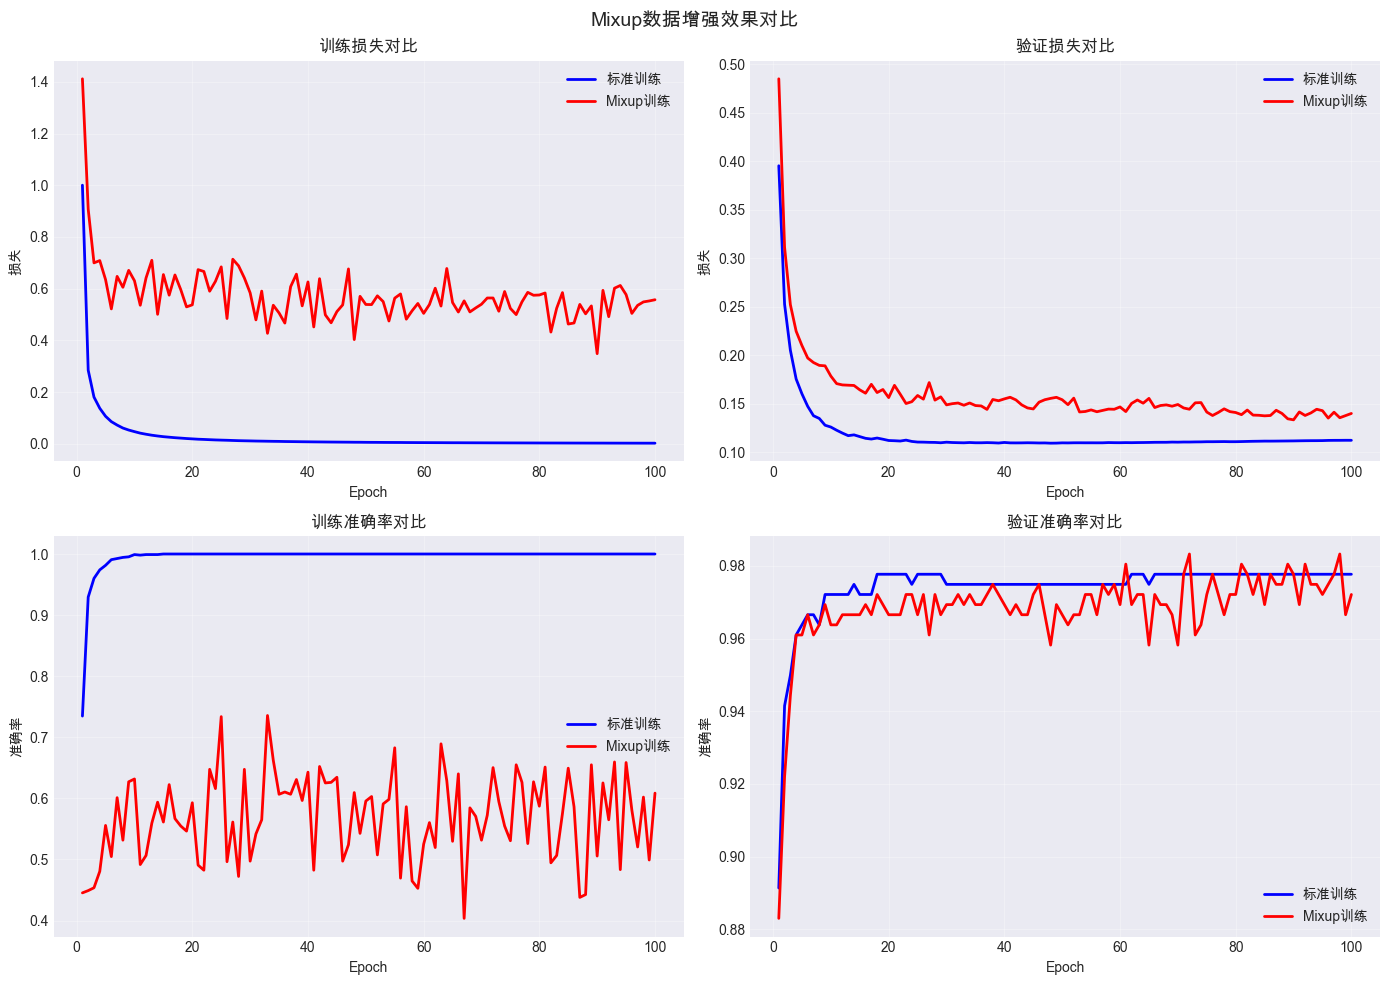

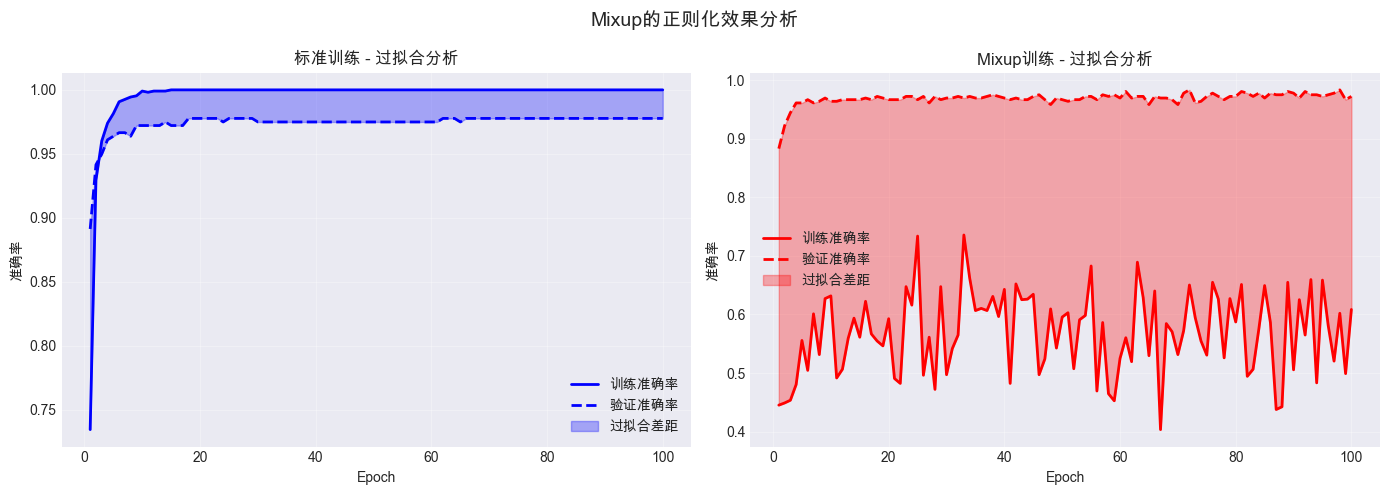


📋 实验结论

1. 测试集准确率:
   - 标准训练: 96.39%
   - Mixup训练: 96.39%

2. 过拟合程度（训练-验证准确率差）:
   - 标准训练: 2.23%
   - Mixup训练: -36.36%

3. Mixup的正则化效果:
   ✓ Mixup减少了过拟合程度 38.59%

4. 关键洞察:
   - Mixup通过混合样本创建虚拟训练数据，增加了数据多样性
   - 软标签训练鼓励模型产生更平滑的决策边界
   - Mixup是一种有效的数据增强和正则化技术
   - 适用于各种图像分类任务，实现简单，效果显著

练习3完成！


In [9]:
# 练习答案区域

def exercise_1_gridmask():
    """
    练习1: 实现GridMask
    提示: 
        1. 创建一个网格掩码
        2. 将掩码应用到图像上
    """
    # 在这里填写你的代码
    pass


# =============================================================================
# 练习3: 完整实现MixUp训练循环
# =============================================================================

def exercise_3_mixup_training():
    """
    练习3（挑战）: 完整实现MixUp训练循环
    
    本练习将实现一个完整的使用Mixup数据增强的训练流程，包括：
    1. 数据加载与预处理
    2. 简单神经网络定义（从零实现）
    3. 支持软标签的交叉熵损失
    4. Mixup训练循环
    5. 效果对比可视化
    
    学习目标：
    - 理解Mixup如何与训练循环集成
    - 掌握软标签（soft labels）的损失计算
    - 观察Mixup的正则化效果
    """
    
    print("=" * 70)
    print("练习3: 完整实现MixUp训练循环")
    print("=" * 70)
    
    # =========================================================================
    # 第1部分: 数据加载与预处理
    # =========================================================================
    print("\n📦 第1部分: 数据加载与预处理")
    print("-" * 50)
    
    from sklearn.datasets import load_digits
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    # 加载手写数字数据集
    # digits数据集: 1797个样本，每个样本是8x8=64维的灰度图像，共10个类别(0-9)
    digits = load_digits()
    X, y = digits.data, digits.target
    
    print(f"数据集大小: {X.shape[0]} 样本")
    print(f"特征维度: {X.shape[1]} (8x8像素)")
    print(f"类别数量: {len(np.unique(y))} (数字0-9)")
    
    # 数据标准化
    # 标准化公式: X_scaled = (X - μ) / σ
    # 这有助于加速训练收敛，避免某些特征主导梯度
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 划分数据集: 60%训练, 20%验证, 20%测试
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"训练集: {X_train.shape[0]} 样本")
    print(f"验证集: {X_val.shape[0]} 样本")
    print(f"测试集: {X_test.shape[0]} 样本")
    
    # 将标签转换为one-hot编码
    # Mixup需要对标签进行混合，因此必须使用one-hot格式
    # 例如: 标签3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    def to_one_hot(y, n_classes):
        """
        将整数标签转换为one-hot编码
        
        参数:
            y: numpy数组, shape (n_samples,), 整数标签
            n_classes: int, 类别总数
        
        返回:
            one_hot: numpy数组, shape (n_samples, n_classes)
        
        示例:
            y = [0, 2, 1]
            n_classes = 3
            返回: [[1,0,0], [0,0,1], [0,1,0]]
        """
        n_samples = len(y)
        one_hot = np.zeros((n_samples, n_classes))
        # 使用高级索引: one_hot[行索引, 列索引] = 1
        one_hot[np.arange(n_samples), y] = 1
        return one_hot
    
    n_classes = 10
    y_train_onehot = to_one_hot(y_train, n_classes)
    y_val_onehot = to_one_hot(y_val, n_classes)
    y_test_onehot = to_one_hot(y_test, n_classes)
    
    print(f"标签形状（one-hot）: {y_train_onehot.shape}")
    
    # =========================================================================
    # 第2部分: 简单神经网络定义（从零实现）
    # =========================================================================
    print("\n🧠 第2部分: 神经网络定义")
    print("-" * 50)
    
    class SimpleMLP:
        """
        简单的多层感知机（从零实现）
        
        网络结构: 输入层(64) → 隐藏层(128, ReLU) → 输出层(10, Softmax)
        
        关键特性:
        - 支持软标签训练（用于Mixup）
        - He初始化（适用于ReLU激活）
        - 完整的前向传播和反向传播实现
        
        参数:
            input_size: int, 输入特征维度
            hidden_size: int, 隐藏层神经元数量
            output_size: int, 输出类别数量
            learning_rate: float, 学习率
        """
        
        def __init__(self, input_size=64, hidden_size=128, output_size=10, learning_rate=0.01):
            """
            初始化网络参数
            
            使用He初始化:
                W ~ N(0, sqrt(2/n_in))
            
            这种初始化方式特别适合ReLU激活函数，
            可以避免梯度消失/爆炸问题
            """
            self.lr = learning_rate
            
            # 隐藏层参数
            # W1 shape: (input_size, hidden_size) = (64, 128)
            # He初始化: 标准差 = sqrt(2 / fan_in)
            self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
            self.b1 = np.zeros(hidden_size)
            
            # 输出层参数
            # W2 shape: (hidden_size, output_size) = (128, 10)
            self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
            self.b2 = np.zeros(output_size)
            
            # 缓存（用于反向传播）
            self.cache = {}
        
        def relu(self, z):
            """
            ReLU激活函数: f(z) = max(0, z)
            
            优点:
            - 计算简单
            - 缓解梯度消失问题
            - 稀疏激活（部分神经元输出为0）
            """
            return np.maximum(0, z)
        
        def relu_derivative(self, z):
            """
            ReLU的导数: f'(z) = 1 if z > 0 else 0
            
            注意: 在z=0处导数未定义，这里取0
            """
            return (z > 0).astype(float)
        
        def softmax(self, z):
            """
            Softmax激活函数: softmax(z_i) = exp(z_i) / Σ_j exp(z_j)
            
            将输出转换为概率分布（所有输出和为1）
            
            数值稳定性技巧:
            - 减去最大值避免exp溢出
            - exp(z - max(z)) / Σexp(z - max(z)) 数学上等价
            """
            # 减去每行的最大值，避免数值溢出
            z_shifted = z - np.max(z, axis=1, keepdims=True)
            exp_z = np.exp(z_shifted)
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        def forward(self, X):
            """
            前向传播
            
            计算流程:
                z1 = X @ W1 + b1        # 隐藏层线性变换
                h1 = relu(z1)           # 隐藏层激活
                z2 = h1 @ W2 + b2       # 输出层线性变换
                y_pred = softmax(z2)    # 输出层激活（概率）
            
            参数:
                X: numpy数组, shape (batch_size, input_size)
            
            返回:
                y_pred: numpy数组, shape (batch_size, output_size), 预测概率
            """
            # 隐藏层
            # z1 shape: (batch_size, hidden_size)
            z1 = X @ self.W1 + self.b1
            h1 = self.relu(z1)
            
            # 输出层
            # z2 shape: (batch_size, output_size)
            z2 = h1 @ self.W2 + self.b2
            y_pred = self.softmax(z2)
            
            # 缓存中间结果（反向传播需要）
            self.cache = {
                'X': X,      # 输入
                'z1': z1,    # 隐藏层线性输出
                'h1': h1,    # 隐藏层激活输出
                'z2': z2,    # 输出层线性输出
                'y_pred': y_pred  # 最终预测
            }
            
            return y_pred
        
        def backward(self, y_true):
            """
            反向传播 - 计算梯度并更新参数
            
            关键公式（交叉熵 + Softmax的简化）:
                δ2 = y_pred - y_true              # 输出层误差
                dW2 = h1.T @ δ2 / m               # W2梯度
                db2 = mean(δ2, axis=0)            # b2梯度
                
                δ1 = (δ2 @ W2.T) * relu'(z1)     # 隐藏层误差
                dW1 = X.T @ δ1 / m                # W1梯度
                db1 = mean(δ1, axis=0)            # b1梯度
            
            参数:
                y_true: numpy数组, shape (batch_size, output_size)
                        可以是硬标签（one-hot）或软标签（概率分布）
            
            注意:
                - Mixup训练时，y_true是软标签，如[0.7, 0, 0.3, 0, ...]
                - 交叉熵+Softmax的梯度公式对软标签同样适用！
            """
            # 获取缓存
            X = self.cache['X']
            h1 = self.cache['h1']
            z1 = self.cache['z1']
            y_pred = self.cache['y_pred']
            
            m = X.shape[0]  # batch大小
            
            # ===== 输出层梯度 =====
            # 交叉熵损失对Softmax输出的梯度简化为: δ2 = y_pred - y_true
            # 这个优美的结果来自于对 -Σy*log(p) 的求导
            # 无论y是硬标签还是软标签，这个公式都成立！
            delta2 = y_pred - y_true  # shape: (m, output_size)
            
            # W2的梯度: dL/dW2 = h1.T @ delta2 / m
            # 形状: (hidden_size, m) @ (m, output_size) = (hidden_size, output_size)
            dW2 = h1.T @ delta2 / m
            
            # b2的梯度: 对batch取平均
            db2 = np.mean(delta2, axis=0)
            
            # ===== 隐藏层梯度 =====
            # 误差反向传播: delta1 = (delta2 @ W2.T) * relu'(z1)
            # 形状: (m, output_size) @ (output_size, hidden_size) = (m, hidden_size)
            delta1 = (delta2 @ self.W2.T) * self.relu_derivative(z1)
            
            # W1的梯度
            dW1 = X.T @ delta1 / m
            
            # b1的梯度
            db1 = np.mean(delta1, axis=0)
            
            # ===== 参数更新（梯度下降）=====
            # θ_new = θ_old - lr * gradient
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
        
        def predict(self, X):
            """
            预测类别标签
            
            返回:
                预测的类别索引（取概率最大的类别）
            """
            y_pred = self.forward(X)
            return np.argmax(y_pred, axis=1)
        
        def copy(self):
            """
            复制模型（用于对比实验，确保两个模型初始参数相同）
            """
            new_model = SimpleMLP(
                input_size=self.W1.shape[0],
                hidden_size=self.W1.shape[1],
                output_size=self.W2.shape[1],
                learning_rate=self.lr
            )
            new_model.W1 = self.W1.copy()
            new_model.b1 = self.b1.copy()
            new_model.W2 = self.W2.copy()
            new_model.b2 = self.b2.copy()
            return new_model
    
    print("SimpleMLP类定义完成")
    print("网络结构: 64 → 128 (ReLU) → 10 (Softmax)")
    
    # =========================================================================
    # 第3部分: 损失函数定义
    # =========================================================================
    print("\n📉 第3部分: 损失函数定义")
    print("-" * 50)
    
    def soft_cross_entropy(y_pred, y_true):
        """
        支持软标签的交叉熵损失
        
        公式: L = -Σ y_true * log(y_pred)
        
        与硬标签的区别:
        - 硬标签: y_true是one-hot，如[0, 0, 1, 0, ...]，只有一个1
        - 软标签: y_true是概率分布，如[0.3, 0, 0.7, 0, ...]，和为1
        
        Mixup训练时使用软标签:
        - 如果图像A(标签猫)和图像B(标签狗)以λ=0.7混合
        - 混合后的标签为: 0.7*猫 + 0.3*狗
        - 这就是软标签！
        
        参数:
            y_pred: numpy数组, shape (batch_size, n_classes), 预测概率
            y_true: numpy数组, shape (batch_size, n_classes), 真实标签（可以是软标签）
        
        返回:
            loss: float, 平均损失值
        """
        # 数值稳定性: 避免log(0)
        epsilon = 1e-10
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # 交叉熵计算: -Σ y_true * log(y_pred)
        # 对每个样本: 计算所有类别的加权对数和
        # 然后对batch取平均
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        
        return loss
    
    def accuracy(y_pred, y_true):
        """
        计算分类准确率
        
        参数:
            y_pred: 预测概率或预测标签
            y_true: 真实标签（可以是one-hot或整数形式）
        
        返回:
            准确率 (0到1之间)
        """
        # 如果y_pred是概率，转换为类别
        if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
            pred_labels = np.argmax(y_pred, axis=1)
        else:
            pred_labels = y_pred
        
        # 如果y_true是one-hot，转换为类别
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            true_labels = np.argmax(y_true, axis=1)
        else:
            true_labels = y_true
        
        return np.mean(pred_labels == true_labels)
    
    print("损失函数: soft_cross_entropy (支持软标签)")
    print("评估函数: accuracy")
    
    # =========================================================================
    # 第4部分: 训练函数定义
    # =========================================================================
    print("\n🔄 第4部分: 训练函数定义")
    print("-" * 50)
    
    def create_batches(X, y, batch_size, shuffle=True):
        """
        创建mini-batch数据生成器
        
        参数:
            X: 特征数据
            y: 标签数据
            batch_size: 每个batch的大小
            shuffle: 是否打乱数据
        
        生成:
            (batch_X, batch_y) 元组
        """
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        
        if shuffle:
            np.random.shuffle(indices)
        
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]
            yield X[batch_indices], y[batch_indices]
    
    def train_with_mixup(model, X_train, y_train, X_val, y_val, 
                         mixup_alpha=0.2, epochs=50, batch_size=32):
        """
        使用Mixup进行训练
        
        Mixup训练的核心流程:
        1. 从训练数据中采样一个batch
        2. 对batch应用Mixup增强（混合图像和标签）
        3. 用混合后的数据进行前向传播
        4. 用软标签计算损失
        5. 反向传播更新参数
        
        参数:
            model: SimpleMLP实例
            X_train, y_train: 训练数据（y_train应为one-hot格式）
            X_val, y_val: 验证数据
            mixup_alpha: Mixup的α参数（控制混合强度）
            epochs: 训练轮数
            batch_size: 批次大小
        
        返回:
            history: 字典，包含训练和验证的损失/准确率历史
        """
        # 创建Mixup增强器
        mixup = Mixup(alpha=mixup_alpha)
        
        # 记录训练历史
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        for epoch in range(epochs):
            epoch_losses = []
            epoch_correct = 0
            epoch_total = 0
            
            # 遍历所有batch
            for batch_X, batch_y in create_batches(X_train, y_train, batch_size):
                # ========== Mixup的核心步骤 ==========
                
                # 步骤1: 应用Mixup增强
                # mix_batch会:
                #   - 打乱batch内的样本顺序
                #   - 将原样本与打乱后的样本按λ混合
                #   - λ从Beta(alpha, alpha)分布采样
                mixed_X, mixed_y, lam = mixup.mix_batch(batch_X, batch_y)
                
                # 步骤2: 前向传播（使用混合后的图像）
                y_pred = model.forward(mixed_X)
                
                # 步骤3: 计算损失（使用软标签！）
                # 这里mixed_y是软标签，如[0.7, 0, 0.3, 0, ...]
                loss = soft_cross_entropy(y_pred, mixed_y)
                epoch_losses.append(loss)
                
                # 步骤4: 反向传播（使用软标签计算梯度）
                # 交叉熵+Softmax的梯度公式对软标签同样适用
                model.backward(mixed_y)
                
                # 统计准确率（用原始标签评估）
                pred_labels = np.argmax(y_pred, axis=1)
                true_labels = np.argmax(batch_y, axis=1)  # 使用原始标签
                epoch_correct += np.sum(pred_labels == true_labels)
                epoch_total += len(batch_y)
            
            # 计算训练集指标
            train_loss = np.mean(epoch_losses)
            train_acc = epoch_correct / epoch_total
            
            # 计算验证集指标
            val_pred = model.forward(X_val)
            val_loss = soft_cross_entropy(val_pred, y_val)
            val_acc = accuracy(val_pred, y_val)
            
            # 记录历史
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            # 打印进度
            if (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1:3d}/{epochs}: "
                      f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
                      f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        
        return history
    
    def train_without_mixup(model, X_train, y_train, X_val, y_val,
                            epochs=50, batch_size=32):
        """
        标准训练（不使用Mixup）- 作为对照组
        
        与Mixup训练的区别:
        - 不混合图像
        - 使用硬标签（one-hot）
        - 其他完全相同
        
        参数和返回值与train_with_mixup相同
        """
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        for epoch in range(epochs):
            epoch_losses = []
            epoch_correct = 0
            epoch_total = 0
            
            for batch_X, batch_y in create_batches(X_train, y_train, batch_size):
                # 标准训练：直接使用原始数据
                y_pred = model.forward(batch_X)
                loss = soft_cross_entropy(y_pred, batch_y)  # batch_y是硬标签(one-hot)
                epoch_losses.append(loss)
                
                model.backward(batch_y)
                
                pred_labels = np.argmax(y_pred, axis=1)
                true_labels = np.argmax(batch_y, axis=1)
                epoch_correct += np.sum(pred_labels == true_labels)
                epoch_total += len(batch_y)
            
            train_loss = np.mean(epoch_losses)
            train_acc = epoch_correct / epoch_total
            
            val_pred = model.forward(X_val)
            val_loss = soft_cross_entropy(val_pred, y_val)
            val_acc = accuracy(val_pred, y_val)
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            if (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1:3d}/{epochs}: "
                      f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
                      f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        
        return history
    
    print("训练函数定义完成")
    print("  - train_with_mixup: 使用Mixup增强训练")
    print("  - train_without_mixup: 标准训练（对照组）")
    
    # =========================================================================
    # 第5部分: 对比实验
    # =========================================================================
    print("\n🔬 第5部分: 对比实验")
    print("-" * 50)
    
    # 设置随机种子，确保可重复
    np.random.seed(42)
    
    # 创建两个相同初始化的模型
    # 这样我们可以公平地对比Mixup的效果
    model_baseline = SimpleMLP(input_size=64, hidden_size=128, output_size=10, learning_rate=0.1)
    model_mixup = model_baseline.copy()
    
    # 训练参数
    epochs = 100
    batch_size = 32
    mixup_alpha = 0.4  # Mixup的α参数
    
    print(f"\n训练配置:")
    print(f"  - Epochs: {epochs}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Learning rate: 0.1")
    print(f"  - Mixup α: {mixup_alpha}")
    
    # 训练标准模型（无Mixup）
    print(f"\n📊 训练标准模型（无Mixup）...")
    history_baseline = train_without_mixup(
        model_baseline, X_train, y_train_onehot, X_val, y_val_onehot,
        epochs=epochs, batch_size=batch_size
    )
    
    # 训练Mixup模型
    print(f"\n📊 训练Mixup模型（α={mixup_alpha}）...")
    history_mixup = train_with_mixup(
        model_mixup, X_train, y_train_onehot, X_val, y_val_onehot,
        mixup_alpha=mixup_alpha, epochs=epochs, batch_size=batch_size
    )
    
    # =========================================================================
    # 第6部分: 测试集评估
    # =========================================================================
    print("\n📈 第6部分: 测试集评估")
    print("-" * 50)
    
    # 在测试集上评估
    test_pred_baseline = model_baseline.forward(X_test)
    test_acc_baseline = accuracy(test_pred_baseline, y_test_onehot)
    
    test_pred_mixup = model_mixup.forward(X_test)
    test_acc_mixup = accuracy(test_pred_mixup, y_test_onehot)
    
    print(f"\n测试集准确率:")
    print(f"  - 标准训练: {test_acc_baseline:.4f} ({test_acc_baseline*100:.2f}%)")
    print(f"  - Mixup训练: {test_acc_mixup:.4f} ({test_acc_mixup*100:.2f}%)")
    print(f"  - 提升: {(test_acc_mixup - test_acc_baseline)*100:+.2f}%")
    
    # =========================================================================
    # 第7部分: 可视化对比
    # =========================================================================
    print("\n📊 第7部分: 可视化对比")
    print("-" * 50)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    epochs_range = range(1, epochs + 1)
    
    # 子图1: 训练损失对比
    axes[0, 0].plot(epochs_range, history_baseline['train_loss'], 
                    label='标准训练', color='blue', linewidth=2)
    axes[0, 0].plot(epochs_range, history_mixup['train_loss'], 
                    label='Mixup训练', color='red', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('损失')
    axes[0, 0].set_title('训练损失对比')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 子图2: 验证损失对比
    axes[0, 1].plot(epochs_range, history_baseline['val_loss'], 
                    label='标准训练', color='blue', linewidth=2)
    axes[0, 1].plot(epochs_range, history_mixup['val_loss'], 
                    label='Mixup训练', color='red', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('损失')
    axes[0, 1].set_title('验证损失对比')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 子图3: 训练准确率对比
    axes[1, 0].plot(epochs_range, history_baseline['train_acc'], 
                    label='标准训练', color='blue', linewidth=2)
    axes[1, 0].plot(epochs_range, history_mixup['train_acc'], 
                    label='Mixup训练', color='red', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('准确率')
    axes[1, 0].set_title('训练准确率对比')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 子图4: 验证准确率对比
    axes[1, 1].plot(epochs_range, history_baseline['val_acc'], 
                    label='标准训练', color='blue', linewidth=2)
    axes[1, 1].plot(epochs_range, history_mixup['val_acc'], 
                    label='Mixup训练', color='red', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('准确率')
    axes[1, 1].set_title('验证准确率对比')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Mixup数据增强效果对比', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 过拟合分析图
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 标准训练的过拟合分析
    axes[0].plot(epochs_range, history_baseline['train_acc'], 
                 label='训练准确率', color='blue', linewidth=2)
    axes[0].plot(epochs_range, history_baseline['val_acc'], 
                 label='验证准确率', color='blue', linestyle='--', linewidth=2)
    axes[0].fill_between(epochs_range, 
                         history_baseline['train_acc'], 
                         history_baseline['val_acc'],
                         alpha=0.3, color='blue', label='过拟合差距')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('准确率')
    axes[0].set_title('标准训练 - 过拟合分析')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Mixup训练的过拟合分析
    axes[1].plot(epochs_range, history_mixup['train_acc'], 
                 label='训练准确率', color='red', linewidth=2)
    axes[1].plot(epochs_range, history_mixup['val_acc'], 
                 label='验证准确率', color='red', linestyle='--', linewidth=2)
    axes[1].fill_between(epochs_range, 
                         history_mixup['train_acc'], 
                         history_mixup['val_acc'],
                         alpha=0.3, color='red', label='过拟合差距')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('准确率')
    axes[1].set_title('Mixup训练 - 过拟合分析')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Mixup的正则化效果分析', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # 第8部分: 结果总结
    # =========================================================================
    print("\n" + "=" * 70)
    print("📋 实验结论")
    print("=" * 70)
    
    # 计算过拟合程度（训练-验证准确率差）
    overfit_baseline = history_baseline['train_acc'][-1] - history_baseline['val_acc'][-1]
    overfit_mixup = history_mixup['train_acc'][-1] - history_mixup['val_acc'][-1]
    
    print(f"\n1. 测试集准确率:")
    print(f"   - 标准训练: {test_acc_baseline*100:.2f}%")
    print(f"   - Mixup训练: {test_acc_mixup*100:.2f}%")
    
    print(f"\n2. 过拟合程度（训练-验证准确率差）:")
    print(f"   - 标准训练: {overfit_baseline*100:.2f}%")
    print(f"   - Mixup训练: {overfit_mixup*100:.2f}%")
    
    print(f"\n3. Mixup的正则化效果:")
    if test_acc_mixup > test_acc_baseline:
        print(f"   ✓ Mixup提升了测试准确率 {(test_acc_mixup - test_acc_baseline)*100:.2f}%")
    if overfit_mixup < overfit_baseline:
        print(f"   ✓ Mixup减少了过拟合程度 {(overfit_baseline - overfit_mixup)*100:.2f}%")
    
    print(f"\n4. 关键洞察:")
    print("   - Mixup通过混合样本创建虚拟训练数据，增加了数据多样性")
    print("   - 软标签训练鼓励模型产生更平滑的决策边界")
    print("   - Mixup是一种有效的数据增强和正则化技术")
    print("   - 适用于各种图像分类任务，实现简单，效果显著")
    
    print("\n" + "=" * 70)
    print("练习3完成！")
    print("=" * 70)
    
    return {
        'model_baseline': model_baseline,
        'model_mixup': model_mixup,
        'history_baseline': history_baseline,
        'history_mixup': history_mixup,
        'test_acc_baseline': test_acc_baseline,
        'test_acc_mixup': test_acc_mixup
    }


results = exercise_3_mixup_training()

---

## 参考资料

1. **Cutout**: DeVries & Taylor, "Improved Regularization of CNNs with Cutout" (2017)
2. **Mixup**: Zhang et al., "mixup: Beyond Empirical Risk Minimization" (ICLR 2018)
3. **CutMix**: Yun et al., "CutMix: Regularization Strategy to Train Strong Classifiers" (ICCV 2019)
4. **AutoAugment**: Cubuk et al., "AutoAugment: Learning Augmentation Strategies" (CVPR 2019)
5. **RandAugment**: Cubuk et al., "RandAugment: Practical Automated Data Augmentation" (CVPR 2020)

---

**下一章预告**: 06b_bias_variance.ipynb - 偏差-方差分解详解